# Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import pandas as pd

# Data 

In [2]:
# The standard path for the popular Netflix dataset on Kaggle
file_path = '/kaggle/input/netflix-shows/netflix_titles.csv'

# Load the data
df = pd.read_csv(file_path)

# Display the first few rows to confirm it loaded correctly
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
df.shape

(8807, 12)

In [4]:
# 1. Identify Numerical Variables
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2. Identify Categorical Variables
# In pandas, strings are usually stored as 'object'
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical Variables ({len(numerical_columns)}): {numerical_columns}")
print(f"Categorical Variables ({len(categorical_columns)}): {categorical_columns}")

Numerical Variables (1): ['release_year']
Categorical Variables (11): ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'rating', 'duration', 'listed_in', 'description']


# Imputation

## High Missing Values (Director, Cast, Country)
For these columns, nearly 10% to 30% of data is missing. Replacing these with the most frequent value (Mode) would heavily bias your results. The best practice here is to use a placeholder string.

Strategy: Categorical Imputation with a constant.

In [5]:
# Filling large missing chunks with 'Unknown'
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')

##  Low Missing Values (Rating, Duration)
Since these have very few missing values (less than 0.1%), you can use the Mode (the most common value).

Strategy: Mode Imputation.

In [6]:
# Fill missing ratings with the most common rating (usually TV-MA)
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

# Fill missing duration with the most common duration
df['duration'] = df['duration'].fillna(df['duration'].mode()[0])

#  Time-Based Missing Values (Date_added)
For date_added, you can either drop the 10 rows (it won't hurt your 8,807-row dataset) or fill them with the most common date.

Strategy: Drop or Mode.

In [7]:
# Option: Drop rows where date_added is missing
df.dropna(subset=['date_added'], inplace=True)

##  Visualizing the Fix
After running the code above, it is standard practice in an assignment to show a "Heatmap" proving that the missing values are gone.

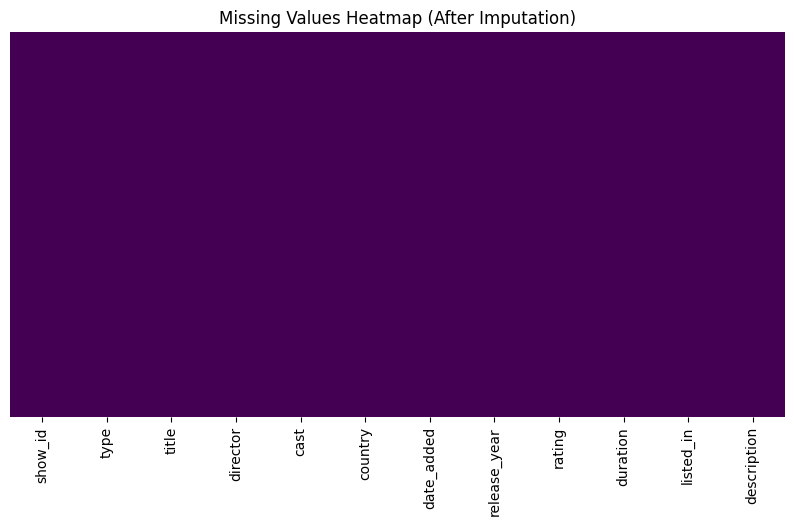

In [8]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap (After Imputation)')
plt.show()

## Introspection

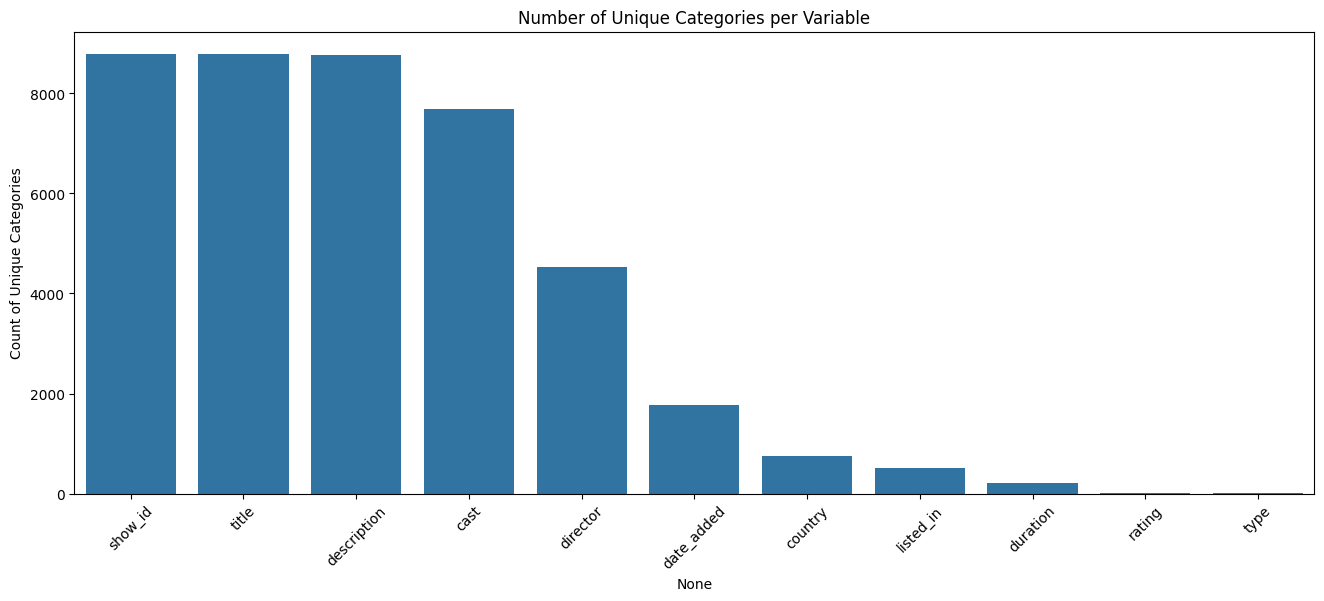

In [9]:
# 1. Calculate unique counts for each column
unique_counts = {col: df[col].nunique() for col in categorical_columns if col in df.columns}
counts_series = pd.Series(unique_counts).sort_values(ascending=False)

# 2. Create the bar chart
plt.figure(figsize=(16, 6))
sns.barplot(x=counts_series.index, y=counts_series.values)

# 3. Add labels
plt.title("Number of Unique Categories per Variable")
plt.ylabel("Count of Unique Categories")
plt.xticks(rotation=45)
plt.show()

## Since these columns have fewer categories,they are much better suited for encoding and visualization.

## Top 10 % Tables for each Categorical var

In [10]:
categorical_columns = ['type', 'country','duration', 'listed_in']

for col in categorical_columns:
    if col in df.columns:
        # 1. Create the table with Count and Percentage
        counts = df[col].value_counts()
        pcts = df[col].value_counts(normalize=True) * 100
        
        # 2. Combine and take top 5
        table = pd.concat([counts, pcts], axis=1).head(5)
        table.columns = ['Count', 'Percentage (%)']
        
        print(f"\n--- Top 5 for {col} ---")
        print(table.round(2))


--- Top 5 for type ---
         Count  Percentage (%)
type                          
Movie     6131           69.69
TV Show   2666           30.31

--- Top 5 for country ---
                Count  Percentage (%)
country                              
United States    2812           31.97
India             972           11.05
Unknown           830            9.44
United Kingdom    418            4.75
Japan             244            2.77

--- Top 5 for duration ---
           Count  Percentage (%)
duration                        
1 Season    1796           20.42
2 Seasons    421            4.79
3 Seasons    198            2.25
90 min       152            1.73
97 min       146            1.66

--- Top 5 for listed_in ---
                                                  Count  Percentage (%)
listed_in                                                              
Dramas, International Movies                        362            4.12
Documentaries                                       359

## Top 10 % charts for each Categorical var

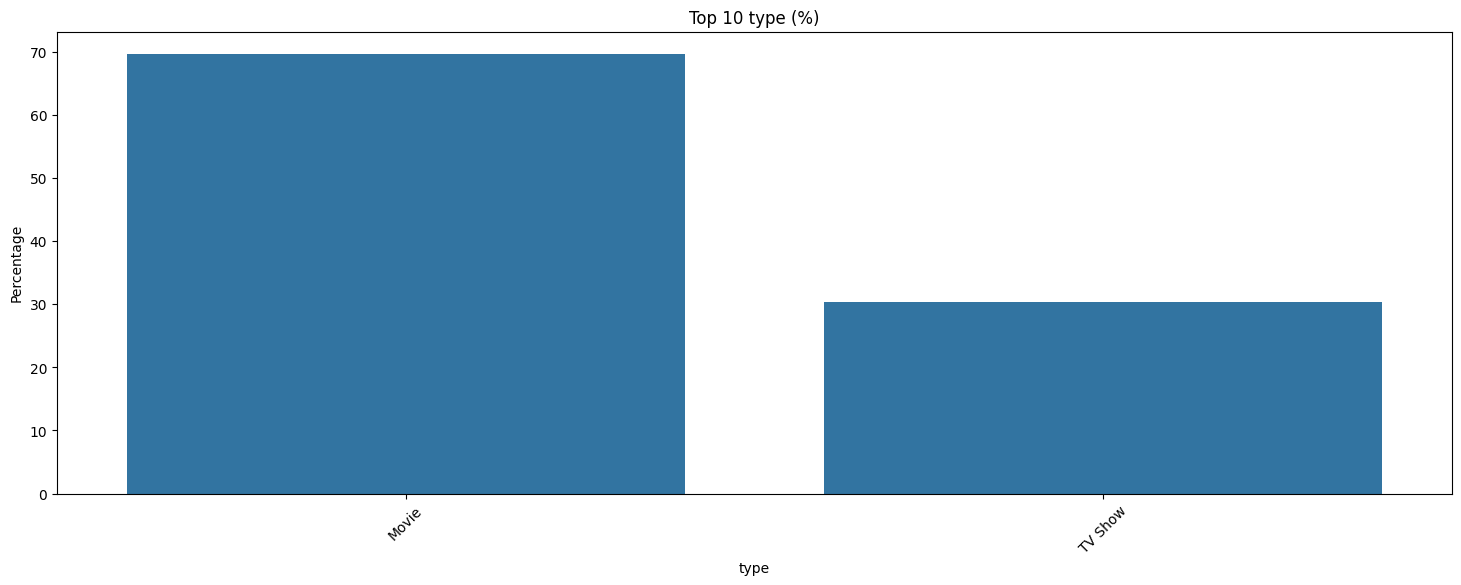

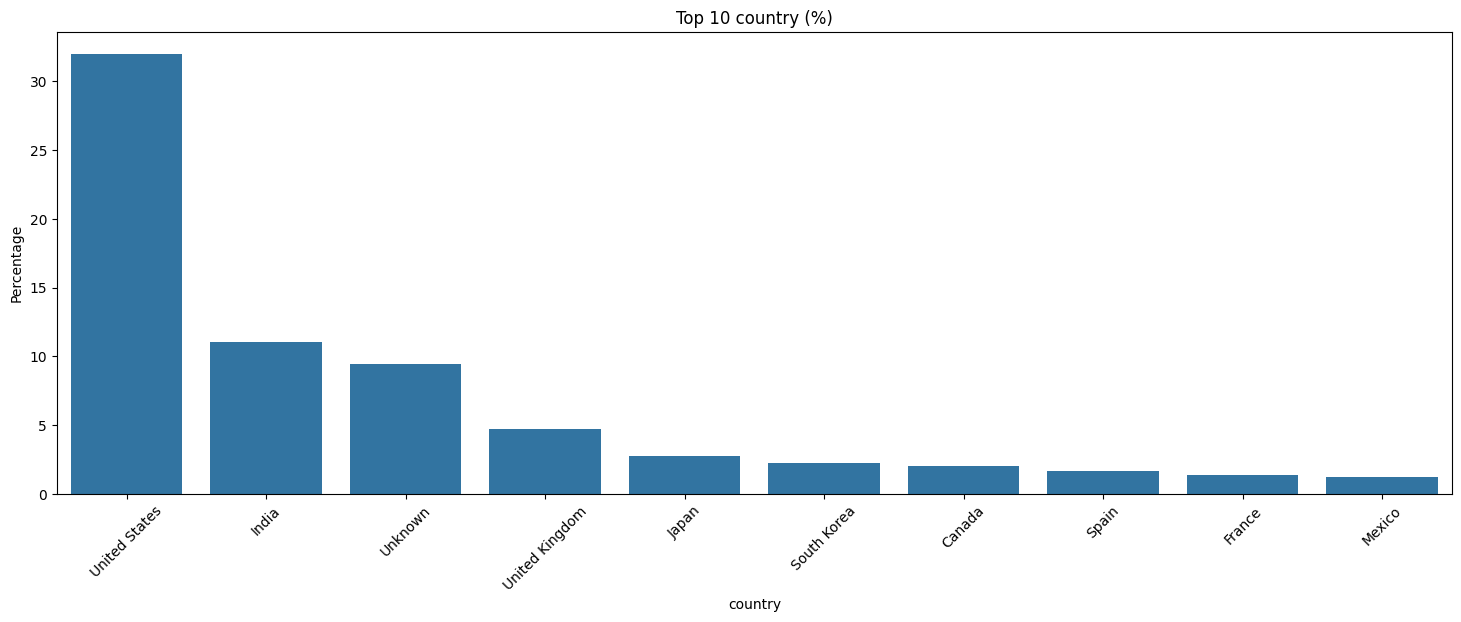

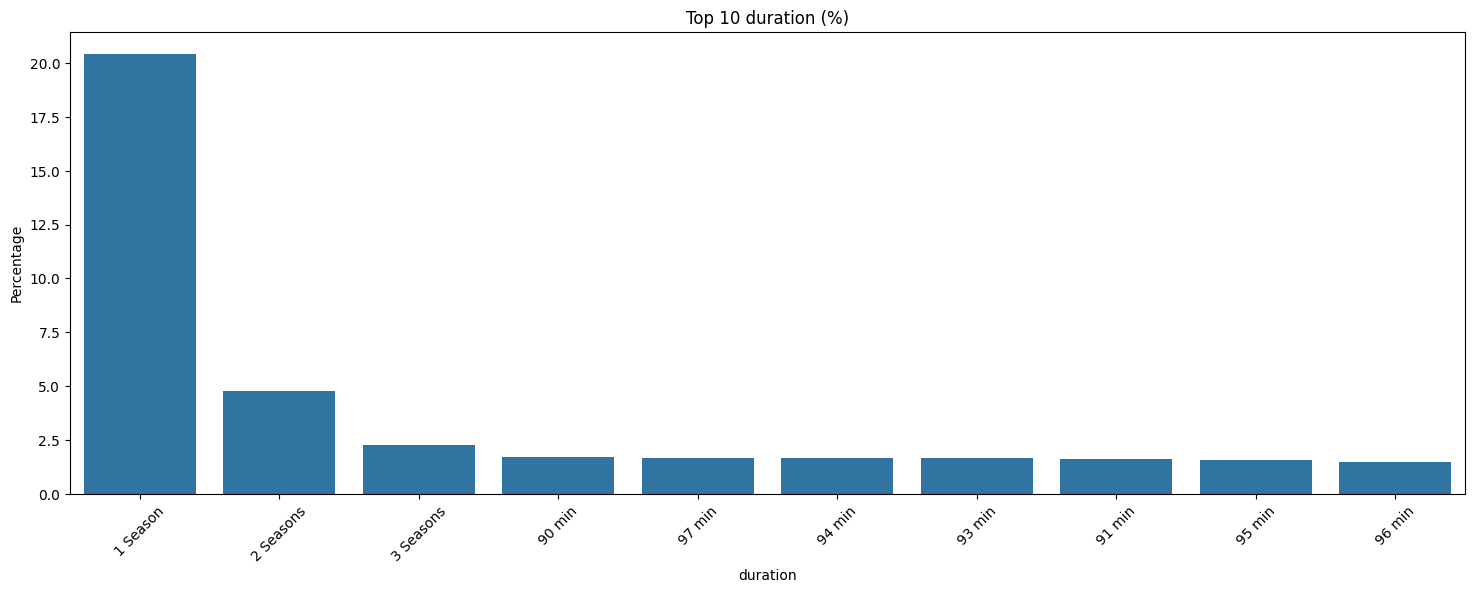

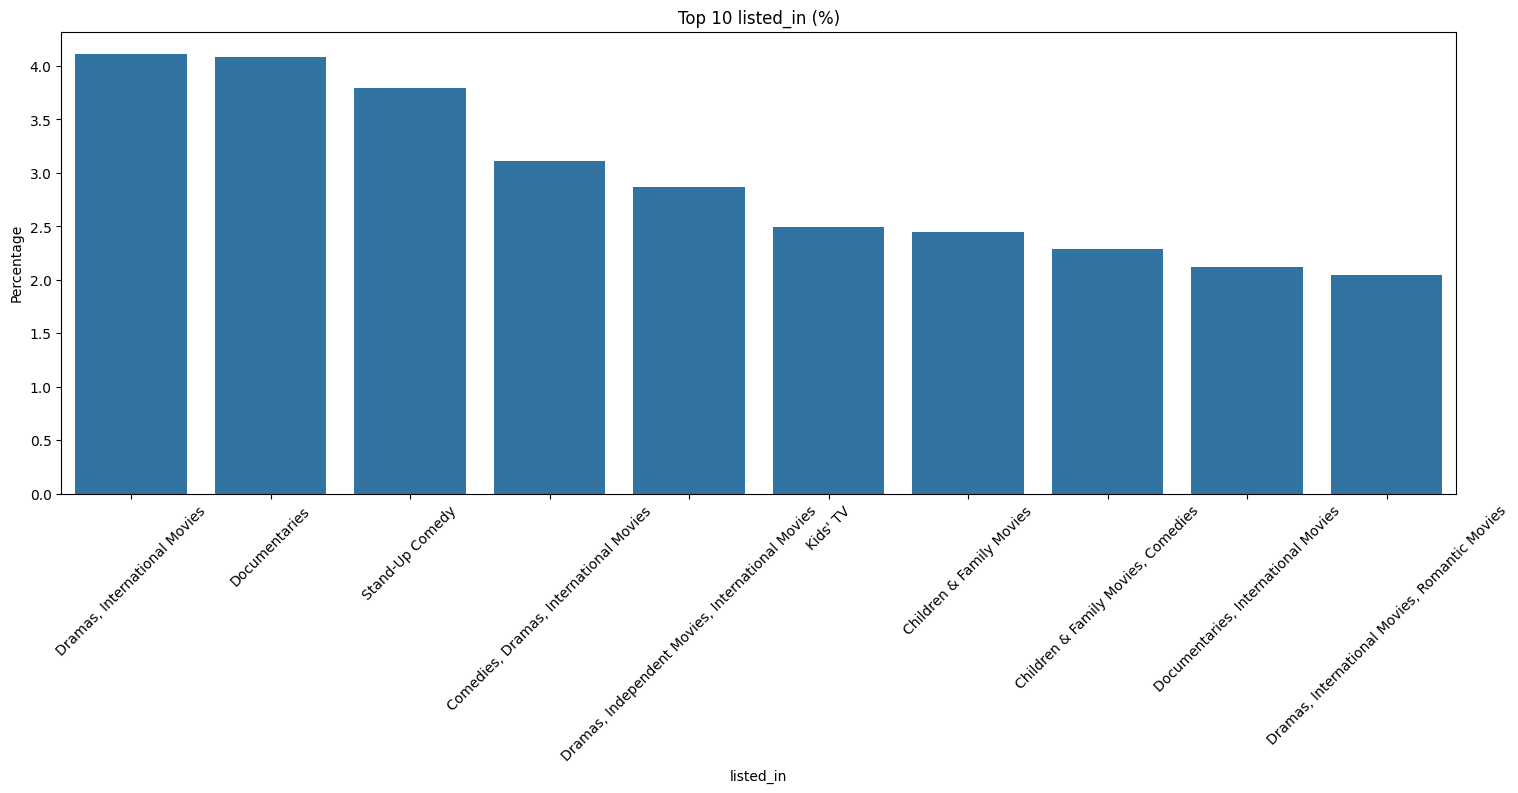

In [11]:
for col in categorical_columns:
    if col in df.columns:
        # 1. Calculate percentage and take top 5
        data = (df[col].value_counts(normalize=True) * 100).head(10)
        
        # 2. Plot
        plt.figure(figsize=(18, 6))
        sns.barplot(x=data.index, y=data.values)
        
        # 3. Simple Labels
        plt.title(f"Top 10 {col} (%)")
        plt.ylabel("Percentage")
        plt.xticks(rotation=45)
        plt.show()

## Cramér's V Correlation

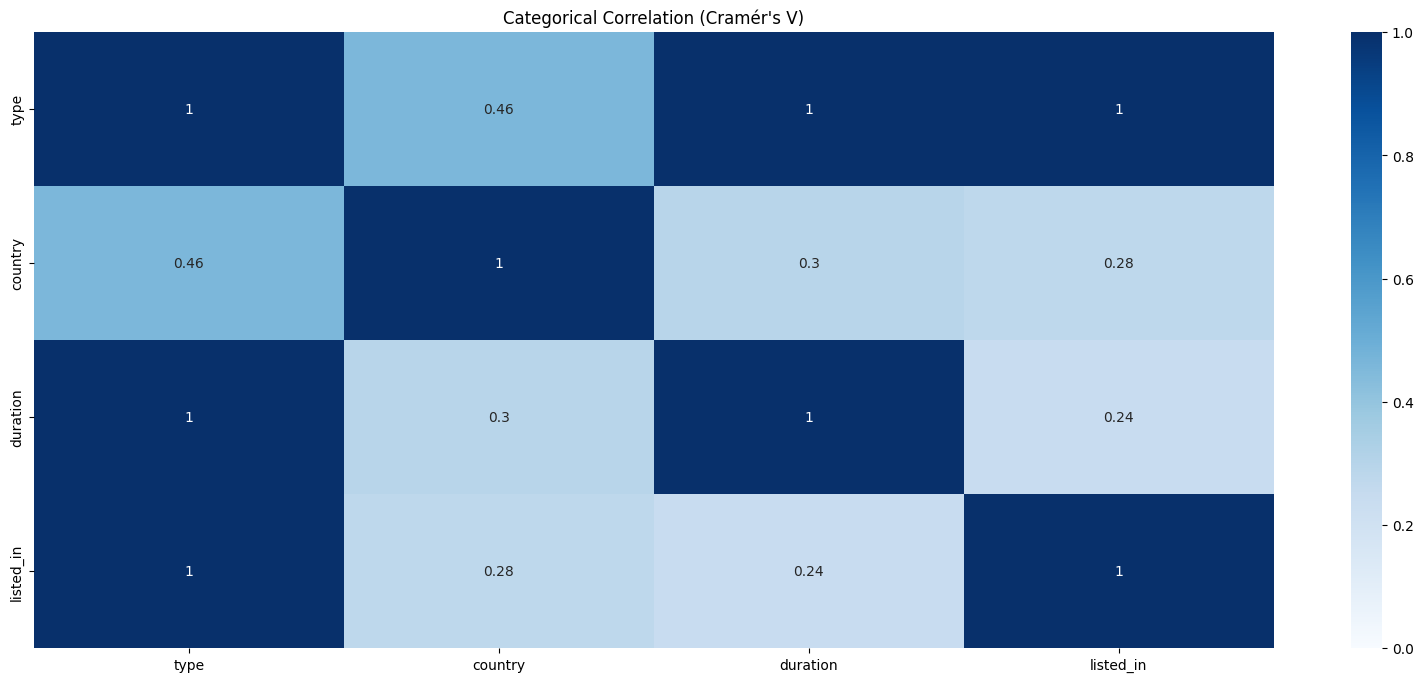

In [12]:
# 1. Define the function for association
def get_cramers_v(col1, col2):
    # Create contingency table
    data = pd.crosstab(df[col1], df[col2])
    # Calculate Chi-square
    chi2 = chi2_contingency(data)[0]
    n = data.sum().sum()
    phi2 = chi2 / n
    r, k = data.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# 2. Build the matrix
v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for c1 in categorical_columns:
    for c2 in categorical_columns:
        v_matrix.loc[c1, c2] = get_cramers_v(c1, c2)

# 3. Plot the result
plt.figure(figsize=(20, 8))
sns.heatmap(v_matrix.astype(float), annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title("Categorical Correlation (Cramér's V)")
plt.show()

## Chi-Square Test

--- Chi-Square Test Results ---
type vs country: p-value = 0.0000
type vs duration: p-value = 0.0000
type vs listed_in: p-value = 0.0000
country vs duration: p-value = 0.0000
country vs listed_in: p-value = 1.0000
duration vs listed_in: p-value = 0.0838


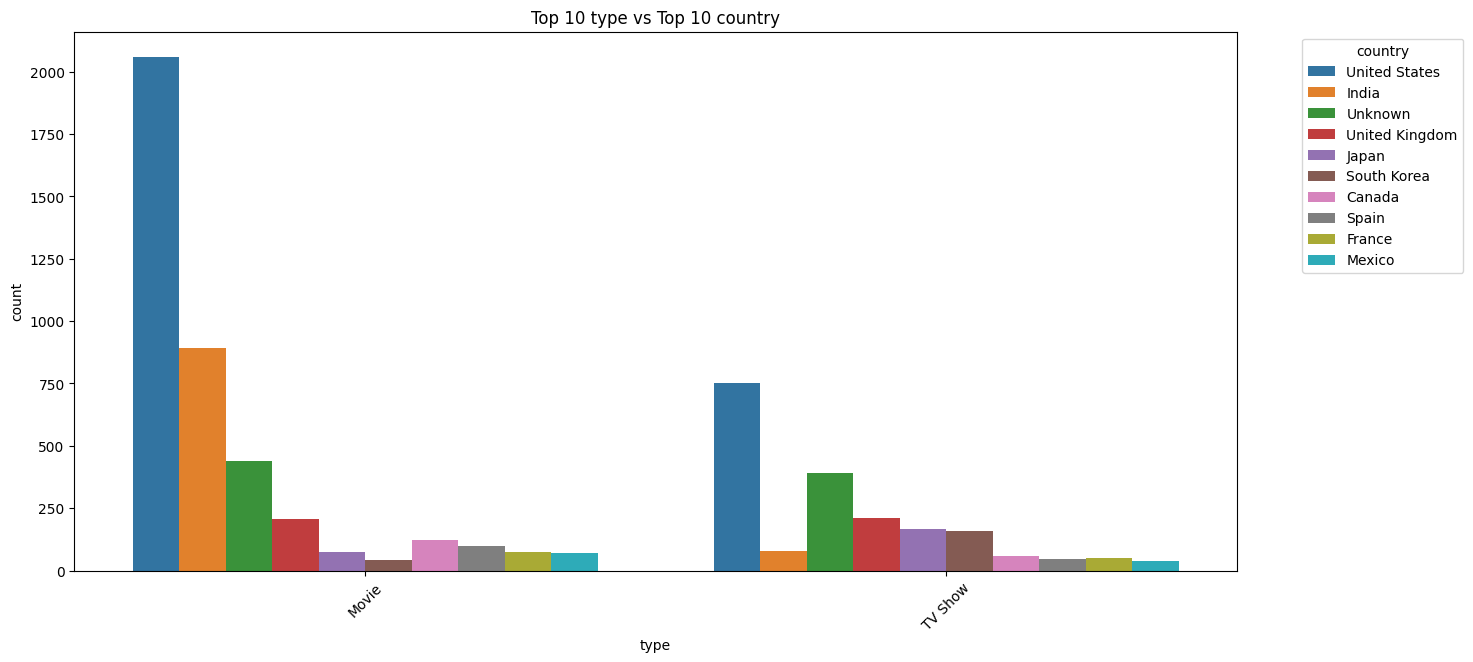

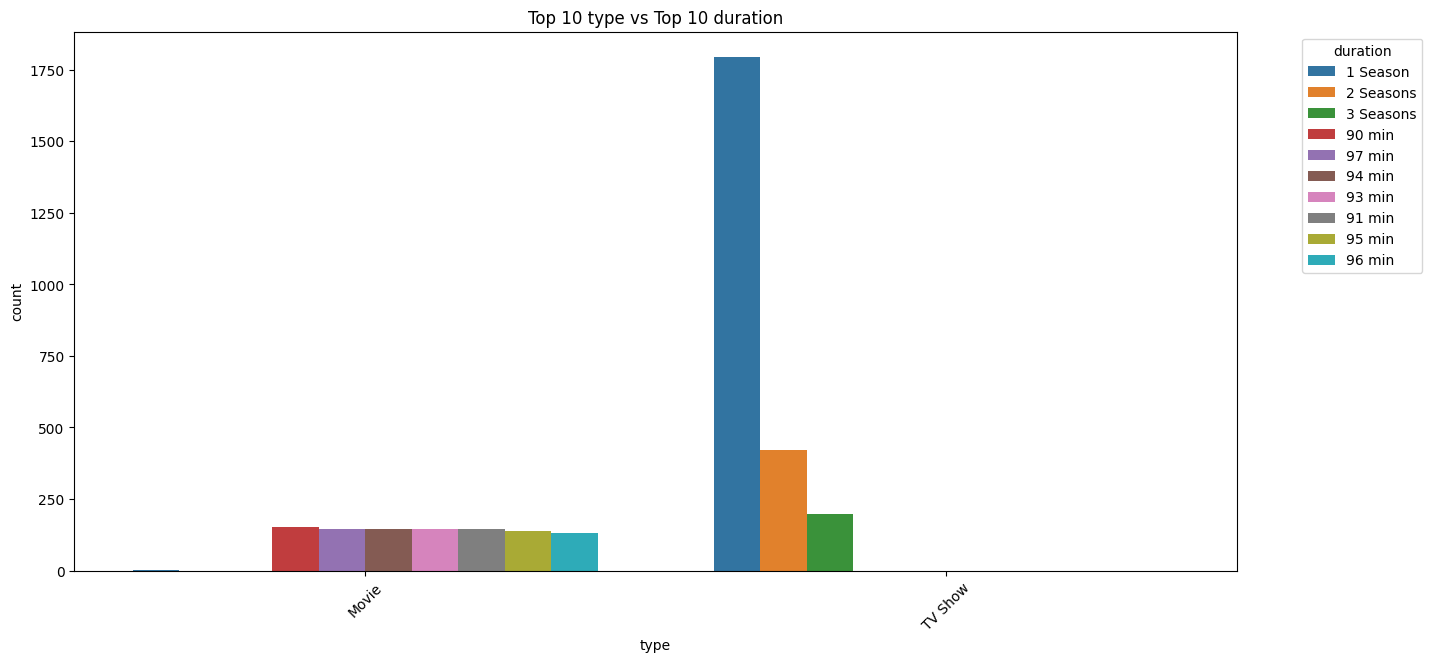

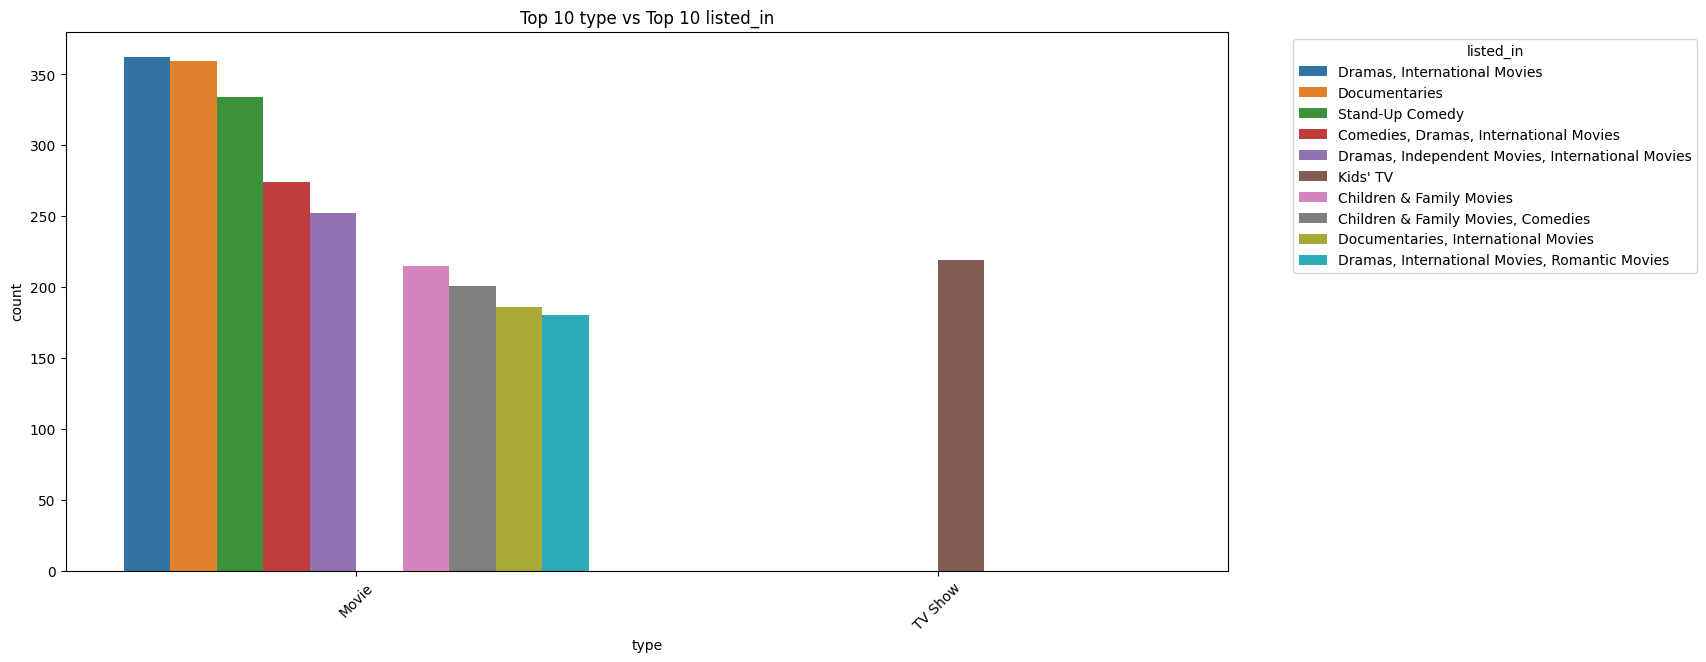

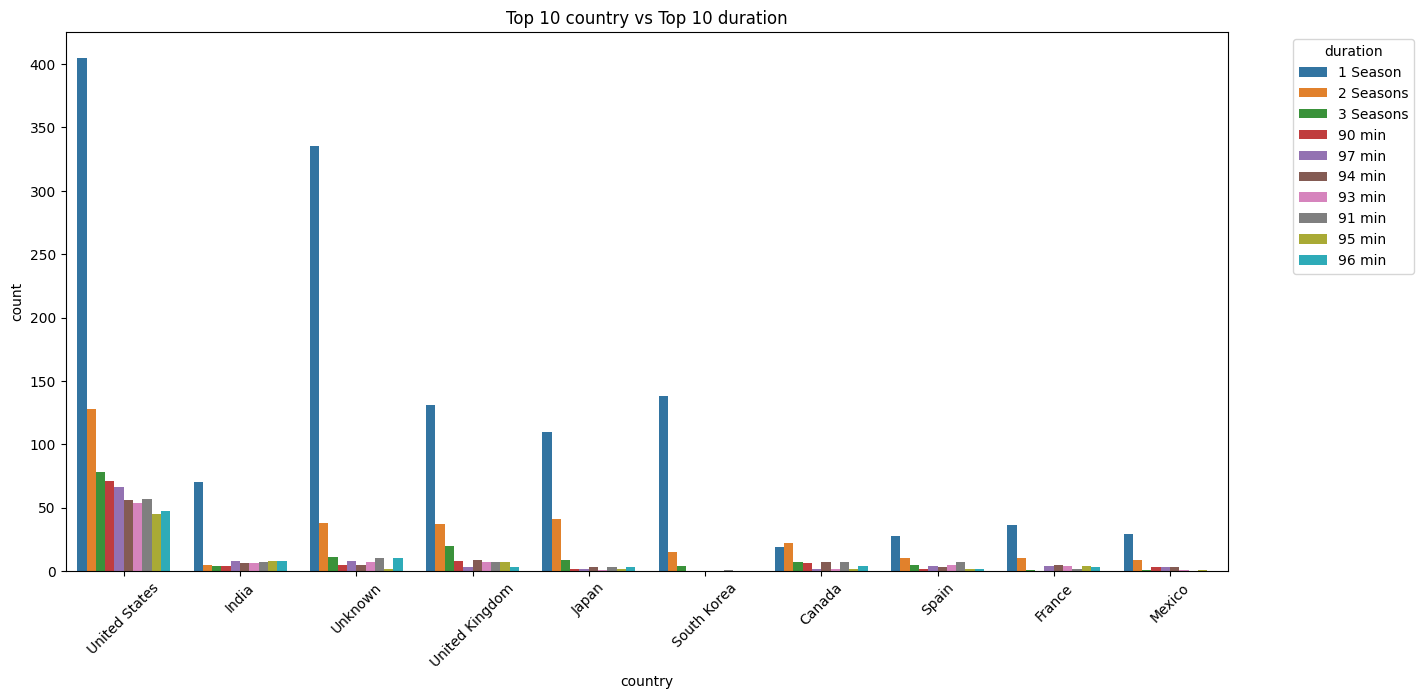

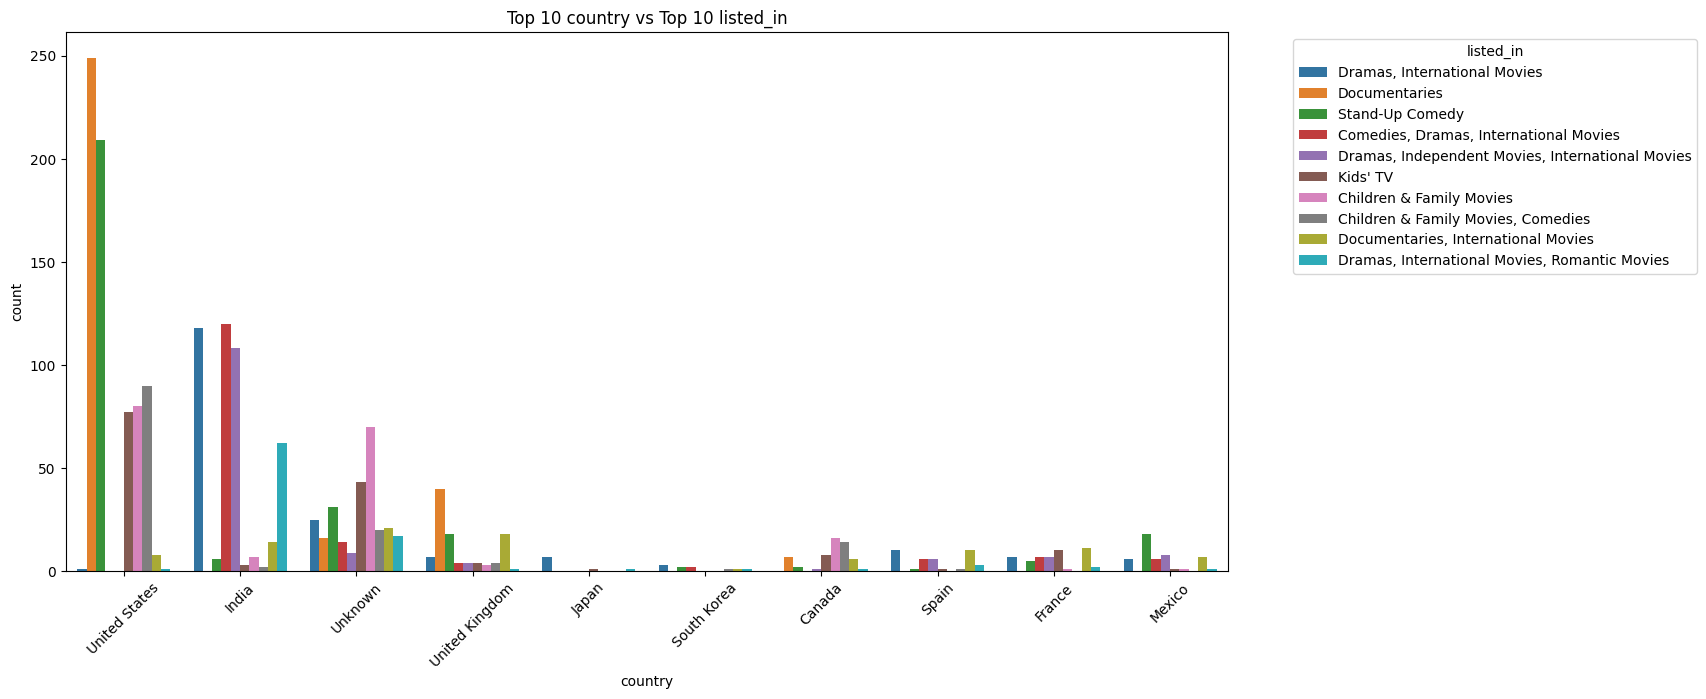

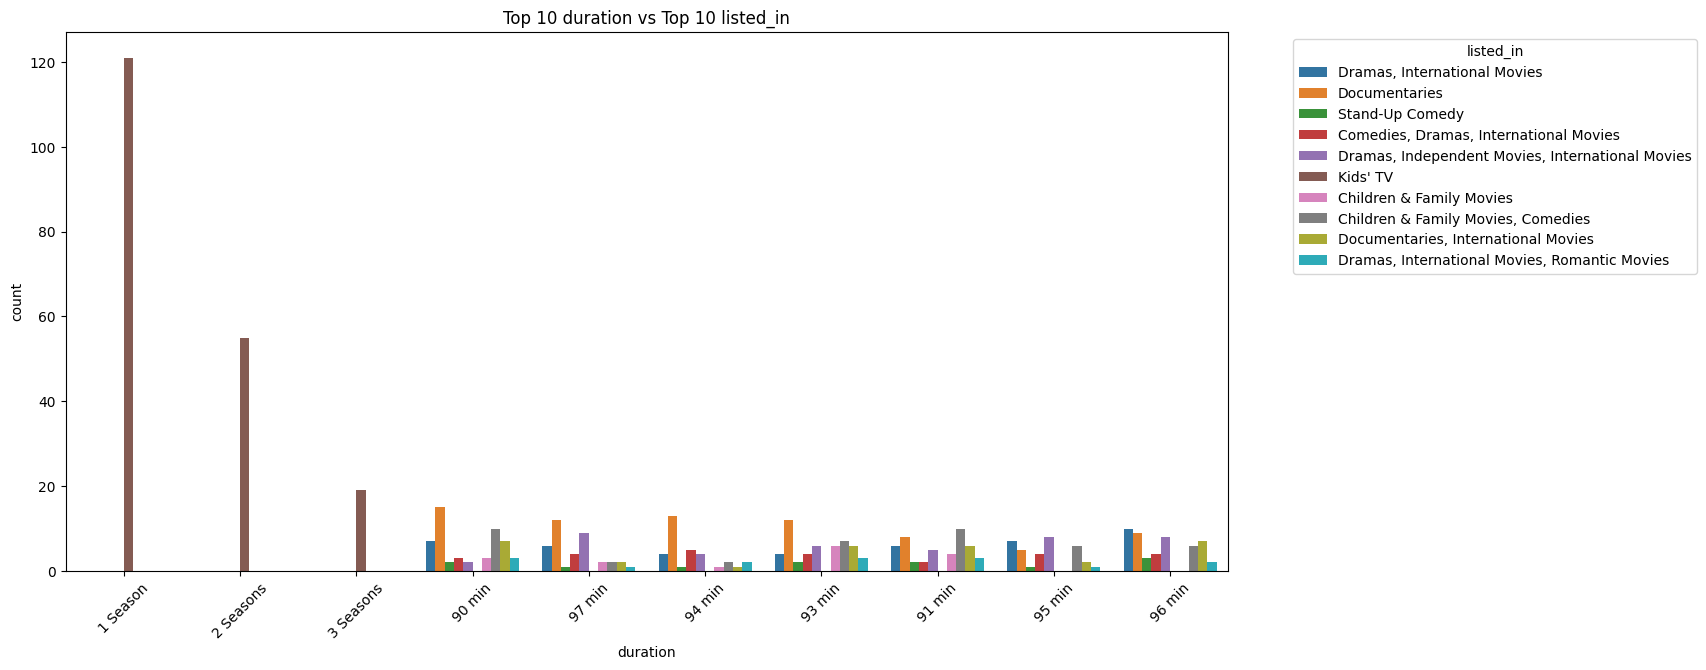

In [13]:
# 1. Chi-Square Test Results
print("--- Chi-Square Test Results ---")
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]
        
        # Contingency table for the test
        ct = pd.crosstab(df[col1], df[col2])
        chi2, p, dof, expected = chi2_contingency(ct)
        
        print(f"{col1} vs {col2}: p-value = {p:.4f}")

# 2. Clustered Bar Charts (Top 10)
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]
        
        # Get Top 10 for both variables to keep the chart clean
        top_10_x = df[col1].value_counts().head(10).index
        top_10_hue = df[col2].value_counts().head(10).index
        
        # Filter data
        plot_df = df[df[col1].isin(top_10_x) & df[col2].isin(top_10_hue)]
        
        plt.figure(figsize=(15, 7))
        sns.countplot(data=plot_df, x=col1, hue=col2, order=top_10_x, hue_order=top_10_hue)
        
        plt.title(f"Top 10 {col1} vs Top 10 {col2}")
        plt.xticks(rotation=45)
        plt.legend(title=col2, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

## Interpretation

### 1. The "Significant" Relationships ()

When the p-value is  (technically just a very small number like ), it means there is a **statistically significant relationship** between the variables.

* **type vs. country/duration/listed_in**: This is expected. For example, `type` (Movie vs. TV Show) strictly dictates `duration` (Minutes vs. Seasons). The "0.0000" proves that these variables are heavily dependent on each other.
* **country vs. duration**: This suggests that different countries have different standards for content length (e.g., Bollywood movies are often longer than US movies).

---

### 2. The "Independent" Relationship ()

**country vs. listed_in**: This is an unusual result. A p-value of  means the variables are **perfectly independent**.

* **The Interpretation**: In your specific dataset, this suggests that the "Genre" (`listed_in`) is distributed across countries in a way that shows zero specific preference.
* **The Reality Check**: Sometimes a  p-value occurs if the data is too "sparse" (too many unique categories with only 1 or 2 entries). Since `country` and `listed_in` both have many unique values, the Chi-Square test might struggle to find a pattern.

---

### 3. The "Borderline" Relationship ()

**duration vs. listed_in**: Since this is **greater than 0.05**, we fail to reject the null hypothesis.

* **The Meaning**: There is no strong evidence that the genre of a show/movie dictates its duration in a consistent way. While some genres might feel longer, the math says the connection isn't strong enough to be a "rule."

---

### Summary Table for your Assignment

| Comparison | P-Value | Conclusion |
| --- | --- | --- |
| **Type vs Country** | 0.0000 | **Strong Correlation** |
| **Type vs Duration** | 0.0000 | **Strong Correlation** |
| **Country vs Listed_in** | 1.0000 | **No Correlation (Independent)** |
| **Duration vs Listed_in** | 0.0838 | **No Significant Correlation** |
